In [ ]:
import tensorflow as tf
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import os, io
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Embedding, Dropout, Dense, Conv1D, GlobalMaxPooling1D,
                          Flatten, Bidirectional, LSTM, GRU, MaxPooling1D)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Sarcasm/website_contents.pickle', 'rb') as f:
  website_contents = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/Sarcasm/labels.pickle', 'rb') as f:
  labels = pickle.load(f)

About 48% of the datasets consists of sarcastic articles. The data we pulled from the websites consists of the headlines and any text found within paragraph tags in the html

In [ ]:
sum(labels)/len(labels)

0.48340425531914893

In [ ]:
def shuffle_data(x,y):
  data = list(zip(x,y))
  random.shuffle(data)
  return zip(*data)

content, labs = shuffle_data(website_contents, labels)

train_content, train_labs = content[:22000], labs[:22000]

valid_content, valid_labs = content[22000:], labs[22000:]

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_size = 50000
oov_token = '<OOV>'

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
tokenizer.fit_on_texts(train_content)
word_index = tokenizer.word_index
word_index = dict([(value, key) for (key,value) in word_index.items()])

token_train_content = tokenizer.texts_to_sequences(train_content)
token_valid_content = tokenizer.texts_to_sequences(valid_content)

In [ ]:
padding_type = 'post'
truncating_type = 'post'
maxlen = 200

x_train = pad_sequences(token_train_content, maxlen = maxlen,
                       padding = padding_type, truncating = truncating_type)
x_valid = pad_sequences(token_valid_content, maxlen = maxlen,
                       padding = padding_type, truncating = truncating_type)

In [ ]:
train_labels = np.array(train_labs)
valid_labels = np.array(valid_labs)

x_train = tf.data.Dataset.from_tensor_slices((x_train, train_labels)) 
x_valid = tf.data.Dataset.from_tensor_slices((x_valid, valid_labels))

x_train = x_train.shuffle(22000).batch(128).prefetch(1)
x_valid = x_valid.shuffle(6000).batch(128).prefetch(1)

In [ ]:
def plot_training_metrics(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  epochs_range = range(len(loss))

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Acc')
  plt.plot(epochs_range, val_acc, label='Validation Acc')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Acc')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
  plt.close()

In [ ]:
def get_embed_visual_files(model):
  # First get the weights of the embedding layer
  e = model.layers[0]
  weights = e.get_weights()[0]
  print(weights.shape) # shape: (vocab_size, embedding_dim)

  # Write out the embedding vectors and metadata
  out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
  out_m = io.open('meta.tsv', 'w', encoding='utf-8')
  for word_num in range(1, vocab_size):
    word = word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
  out_v.close()
  out_m.close()

  # Download the files
  try:
    from google.colab import files
  except ImportError:
    pass
  else:
    files.download('vecs.tsv')
    files.download('meta.tsv')

In [ ]:
tf.keras.backend.clear_session()

embedding_dim = 20

n_epochs = 20

model = Sequential([
                    Embedding(vocab_size, embedding_dim, input_length = maxlen),
                    Bidirectional(LSTM(32)),
                    Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.summary()

history = model.fit(x_train, epochs = n_epochs,  validation_data = x_valid)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 20)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                13568     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,013,633
Trainable params: 1,013,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
172/172 [==============================] - 11s 36ms/step - loss: 0.4884 - accuracy: 0.7845 - val_loss: 0.1192 - val_accuracy: 0.9634
Epoch 2/20
172/172 [==============================] - 5s 28ms/step - loss: 0.0864 - accuracy: 0.9749 - val_loss: 0.0863 - val_accuracy: 0.9666
Epoch 3/20
172/172 [==============================] - 5s 28ms/step - loss: 0.0390 - accur

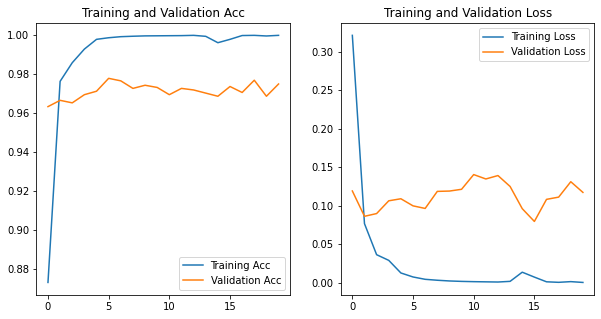

In [ ]:
plot_training_metrics(history)

I wrote a short script found in the get_html_data.py file that will return cleaned text data from a url provided to the function

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Sarcasm')
from get_html_data import get_html_data

In [ ]:
# predictions
def is_sarcastic(model, article_url):
  x = get_html_data(article_url)
  x = tokenizer.texts_to_sequences([x])
  x = pad_sequences(x, maxlen = maxlen,
                    padding=padding_type, truncating = truncating_type)
  prob = model.predict(x)
  if prob > 0.5:
    label = 'sarcastic'
    p = prob[0][0]
  else:
    label = 'NOT sarcastic'
    p = 1 - prob[0][0]
  p  = round(float(p),4)
  print('The article is predicted to be {} with probability {}'.format(label, p))

In [ ]:
url = 'https://www.poughkeepsiejournal.com/story/news/education/2021/04/08/marist-covid-outbreak-person-classes-resume-monday/7149672002/'
is_sarcastic(model, url)

The article is predicted to be NOT sarcastic with probability 0.9992
